# **Rossmann Project**

## **Data**

- data/train.csv - historical data including Sales
- data/test.csv - historical data excluding Sales
- data/store.csv - supplemental information about the stores

## **Import libs**

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2
import math
import pickle

## **Overview**

### **Read data**

In [3]:
df_train = pd.read_csv("data/train.csv", low_memory=False)
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [4]:
df_test = pd.read_csv("data/test.csv")
df_test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [7]:
df_store = pd.read_csv("data/store.csv")
df_store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


### **Merge data**

In [8]:
df = pd.merge(df_train, df_store, on='Store')

In [9]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


### **Shape**

In [10]:
df.shape

(1017209, 18)

## **EDA**

### **Missing values ?**

In [11]:
df.isna().sum().sort_values(ascending=False)

PromoInterval                508031
Promo2SinceWeek              508031
Promo2SinceYear              508031
CompetitionOpenSinceYear     323348
CompetitionOpenSinceMonth    323348
CompetitionDistance            2642
Open                              0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
SchoolHoliday                     0
Promo                             0
StateHoliday                      0
StoreType                         0
Assortment                        0
Promo2                            0
Store                             0
dtype: int64

### **Unique values ?** 

In [12]:
cols = list(df.columns)
cols.remove("Date")
cols.remove("CompetitionDistance")
for col in cols:
    print(col, "---"*15, "\n", df[col].unique(),"\n")

Store --------------------------------------------- 
 [   1    2    3 ... 1113 1114 1115] 

DayOfWeek --------------------------------------------- 
 [5 4 3 2 1 7 6] 

Sales --------------------------------------------- 
 [ 5263  5020  4782 ... 20362 18841 21237] 

Customers --------------------------------------------- 
 [ 555  546  523 ... 3727 4022 4106] 

Open --------------------------------------------- 
 [1 0] 

Promo --------------------------------------------- 
 [1 0] 

StateHoliday --------------------------------------------- 
 ['0' 'a' 'b' 'c'] 

SchoolHoliday --------------------------------------------- 
 [1 0] 

StoreType --------------------------------------------- 
 ['c' 'a' 'd' 'b'] 

Assortment --------------------------------------------- 
 ['a' 'c' 'b'] 

CompetitionOpenSinceMonth --------------------------------------------- 
 [ 9. 11. 12.  4. 10.  8. nan  3.  6.  5.  1.  2.  7.] 

CompetitionOpenSinceYear --------------------------------------------- 
 [2008. 2

### **Sales by Year**

In [13]:
# getting year & month from Date
df['Year'] = df["Date"].apply(lambda x: int(x.split('-')[0]))
df['month'] = df["Date"].apply(lambda x: int(x.split('-')[1]))

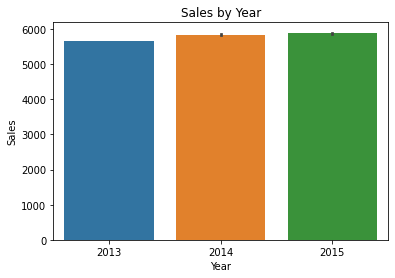

In [14]:
sns.barplot(x='Year', y='Sales', data=df).set(title="Sales by Year")
plt.show()

# Increasing Year to Year

### **Sales by week**

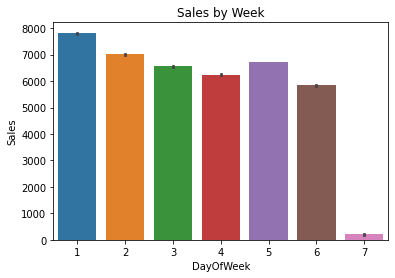

In [15]:
sns.barplot(x='DayOfWeek', y='Sales', data=df).set(title="Sales by Week")
plt.show()

# Monday and Friday are highest

### **Impact of Promo**

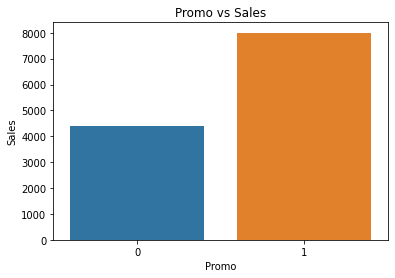

In [16]:
sns.barplot(x='Promo', y='Sales', data=df).set(title='Promo vs Sales')
plt.show()

# if Promo == True : Sales are higner

### **Impact of State Holiday**

StateHoliday - indicates a state holiday.  
Normally all stores, with few exceptions, are closed on state holidays.  
All schools are closed on public holidays and weekends.  
`a` = public holiday   
`b` = Easter holiday  
`c` = Christmas  
`0` = None  

In [ ]:
df["StateHoliday"].value_counts()

0    986159
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

In [ ]:
df["StateHoliday"].dtypes

dtype('O')

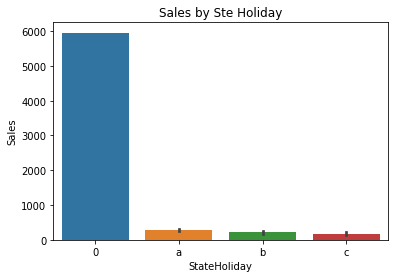

In [ ]:
sns.barplot(x='StateHoliday', y='Sales', data=df).set(title='Sales by State Holiday')
plt.show()

# Less Sales on State Holiday

### **Impact of closure of public schools : School Holiday**

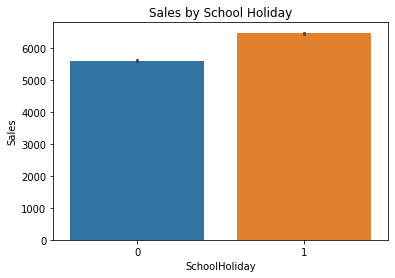

In [ ]:
sns.barplot(x='SchoolHoliday', y='Sales', data=df).set(title='Sales by School Holiday')
plt.show()

# More Sales on School Holiday

### **Sales by StoreType**

In [ ]:
# StoreType - differentiates between 4 different store models: a, b, c, d
df["StoreType"].value_counts()

a    551627
d    312912
c    136840
b     15830
Name: StoreType, dtype: int64

In [ ]:
df["StoreType"].dtype

dtype('O')

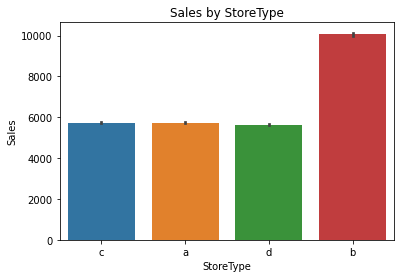

In [ ]:
sns.barplot(x='StoreType', y='Sales', data=df).set(title='Sales by StoreType')
plt.show()

# Store b have the highest sales

### **Impact of Assortment**

In [ ]:
# Assortment - describes an assortment level: a = basic, b = extra, c = extended
df["Assortment"].value_counts()

a    537445
c    471470
b      8294
Name: Assortment, dtype: int64

In [ ]:
df["Assortment"].dtype

dtype('O')

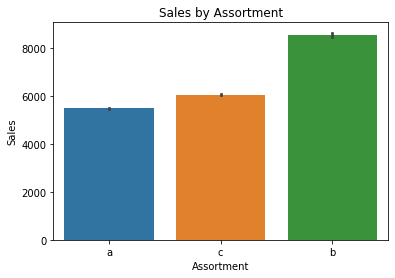

In [ ]:
sns.barplot(x='Assortment', y='Sales', data=df).set(title='Sales by Assortment')
plt.show()

# Level b have the highest sales

## **Missing values**

In [17]:
df_clean = df.copy()

In [18]:
df_clean.isna().sum().sort_values(ascending=False)

PromoInterval                508031
Promo2SinceYear              508031
Promo2SinceWeek              508031
CompetitionOpenSinceYear     323348
CompetitionOpenSinceMonth    323348
CompetitionDistance            2642
month                             0
Promo                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
StoreType                         0
StateHoliday                      0
SchoolHoliday                     0
Year                              0
Assortment                        0
Promo2                            0
Store                             0
dtype: int64

### `PromoInterval` | `Promo2SinceYear` | `Promo2SinceWeek`

**_Method_**: 
- fill null values with `0` because `Promo2` is `0` for those stores

In [19]:
df_clean.update(df[['Promo2SinceWeek','Promo2SinceYear','PromoInterval']].fillna(0))

In [20]:
df_clean.isna().sum().sort_values(ascending=False)

CompetitionOpenSinceYear     323348
CompetitionOpenSinceMonth    323348
CompetitionDistance            2642
month                             0
StateHoliday                      0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StoreType                         0
SchoolHoliday                     0
Year                              0
Assortment                        0
Promo2                            0
Promo2SinceWeek                   0
Promo2SinceYear                   0
PromoInterval                     0
Store                             0
dtype: int64

### `CompetitionOpenSinceYear` | `CompetitionOpenSinceMonth` | `CompetitionDistance`

**_Method_**:
- `CompetitionOpenSinceMonth`, `CompetitionOpenSinceYear` : most occuring month and year respectively
- `CompetitionDistance` :  mean of the distance given for all other stores

In [21]:
df_clean['CompetitionOpenSinceMonth'].fillna(df_clean['CompetitionOpenSinceMonth'].mode()[0],inplace=True)
df_clean['CompetitionOpenSinceYear'].fillna(df_clean['CompetitionOpenSinceYear'].mode()[0],inplace=True)

In [22]:
df_clean.isna().sum().sort_values(ascending=False)

CompetitionDistance          2642
month                           0
SchoolHoliday                   0
DayOfWeek                       0
Date                            0
Sales                           0
Customers                       0
Open                            0
Promo                           0
StateHoliday                    0
StoreType                       0
Year                            0
Assortment                      0
CompetitionOpenSinceMonth       0
CompetitionOpenSinceYear        0
Promo2                          0
Promo2SinceWeek                 0
Promo2SinceYear                 0
PromoInterval                   0
Store                           0
dtype: int64

In [23]:
df_clean['CompetitionDistance'].fillna(df_clean['CompetitionDistance'].mean(), inplace=True)

In [24]:
# Check
df_clean.isna().sum().sum()

0

## **Impact of CompetitionDistance**

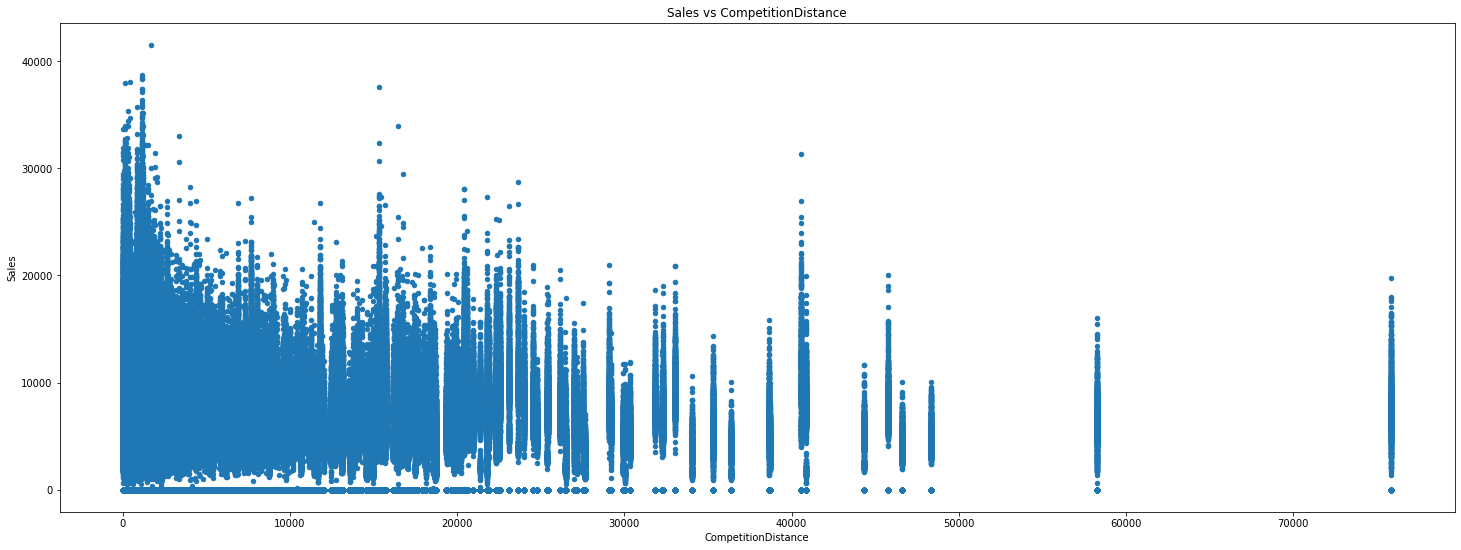

In [27]:
# CompetitionDistance - distance in meters to the nearest competitor store
df.plot(kind='scatter',x='CompetitionDistance',y='Sales',figsize=(25,9),title="Sales vs CompetitionDistance")
plt.show()

# more nearer more sales

## **Outliers**

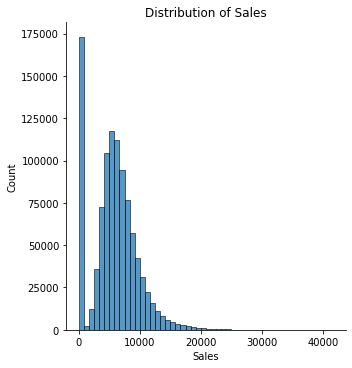

In [30]:
# Distribution of Sales

sns.displot(df_clean, x="Sales",bins=50).set(title='Distribution of Sales')
plt.show()

# Sales greater than 30k are very less => possible outliers

**_Method_**: `z-score`
- If the Z-Score of a datapoint is greater than 3 that can be considered as an Outlier

Mean of Sales:  5773.818972305593
Standard Deviation of Sales:  3849.9242828437527
Total outlier in dataset are:  9731
Maximum Sales Outlier:  41551
Minimum Sales Outlier:  17325


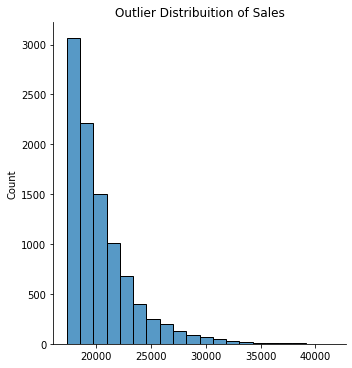

In [32]:
mean_of_sales = np.mean(df_clean['Sales']) 
std_of_sales = np.std(df_clean['Sales'])
print("Mean of Sales: ",mean_of_sales)
print("Standard Deviation of Sales: ",std_of_sales)

threshold = 3
outlier = [] 
for i in df_clean['Sales']: 
    z = (i-mean_of_sales)/std_of_sales
    if z > threshold: 
        outlier.append(i) 
print('Total outlier in dataset are: ', len(outlier))
print("Maximum Sales Outlier: ", max(outlier))
print("Minimum Sales Outlier: ", min(outlier))

sns.displot(x=outlier,bins=20).set(title='Outlier Distribuition of Sales')
plt.show()

In [35]:
# Analyse % of outliers
sales_zero = df_clean.loc[df_clean['Sales'] == 0] 
sales_greater_than_30 = df_clean.loc[df_clean['Sales'] > 30000]

print("Length of actual dataset:", len(df_clean))
print("Length of data where sales is 0:", len(sales_zero),
      " which is", round(len(sales_zero)/len(df_clean)*100,2), "% of the whole data", )

print("Length of data which is greater than 30:", len(sales_greater_than_30),
      "which is ", round(len(sales_greater_than_30)/len(df_clean)*100,2), "% of the whole data")

Length of actual dataset: 1017209
Length of data where sales is 0: 172871  which is 16.99 % of the whole data
Length of data which is greater than 30: 153 which is  0.02 % of the whole data


In [36]:
# Droping sales which are greater than 30k because they are very less in the dataset and probably outliers
df_clean.drop(df_clean.loc[df_clean['Sales'] > 30000].index,inplace=True)
df_clean.shape

(1017056, 20)

### **Exceptional cases**

**_Stores are open and there is no sales on that day_**

In [37]:
# no sales when Stores were Open
no_holiday_zero_sales = df_clean.loc[(df_clean['Sales'] == 0) & (df_clean['Open'] == 1) & 
                                          (df_clean['StateHoliday'] == 0) & (df_clean['SchoolHoliday'] == 0)]

print("Size of the data where sales were zero even when stores were open: ",len(no_holiday_zero_sales))
no_holiday_zero_sales.head()

Size of the data where sales were zero even when stores were open:  0


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,month


In [38]:
# Removing these data points
df_clean.drop(df_clean.loc[(df_clean['Sales'] == 0) & (df_clean['Open'] == 1) & 
                                     (df_clean['StateHoliday'] == 0) & 
                                     (df_clean['SchoolHoliday'] == 0)].index,inplace=True)
df_clean.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,month
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7


## **Categorical to Numeric**

In [39]:
df_clean.drop(['Date'],axis=1,inplace=True)

In [40]:
df_clean.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,month
0,1,5,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7
1,1,4,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7
2,1,3,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7
3,1,2,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7
4,1,1,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7


In [42]:
# Encoding all categorical varibale to numeric values
from sklearn import preprocessing 
label_encoder = preprocessing.LabelEncoder()

df_clean['StoreType']= label_encoder.fit_transform(df_clean['StoreType'])
df_clean['Assortment']= label_encoder.fit_transform(df_clean['Assortment']) 

# Promo Interval
df_clean["PromoInterval"].loc[df_clean["PromoInterval"] == "Jan,Apr,Jul,Oct"] = 1
df_clean["PromoInterval"].loc[df_clean["PromoInterval"] == "Feb,May,Aug,Nov"] = 2
df_clean["PromoInterval"].loc[df_clean["PromoInterval"] == "Mar,Jun,Sept,Dec"] = 3

# State Holiday
df_clean["StateHoliday"].loc[df_clean["StateHoliday"] == "a"] = 1
df_clean["StateHoliday"].loc[df_clean["StateHoliday"] == "b"] = 2
df_clean["StateHoliday"].loc[df_clean["StateHoliday"] == "c"] = 3

df_clean.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,month
0,1,5,5263,555,1,1,0,1,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7
1,1,4,5020,546,1,1,0,1,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7
2,1,3,4782,523,1,1,0,1,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7
3,1,2,5011,560,1,1,0,1,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7
4,1,1,6102,612,1,1,0,1,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7


In [48]:
df_clean['StateHoliday'] = pd.to_numeric(df_clean['StateHoliday'])
df_clean['PromoInterval'] = pd.to_numeric(df_clean['PromoInterval'])

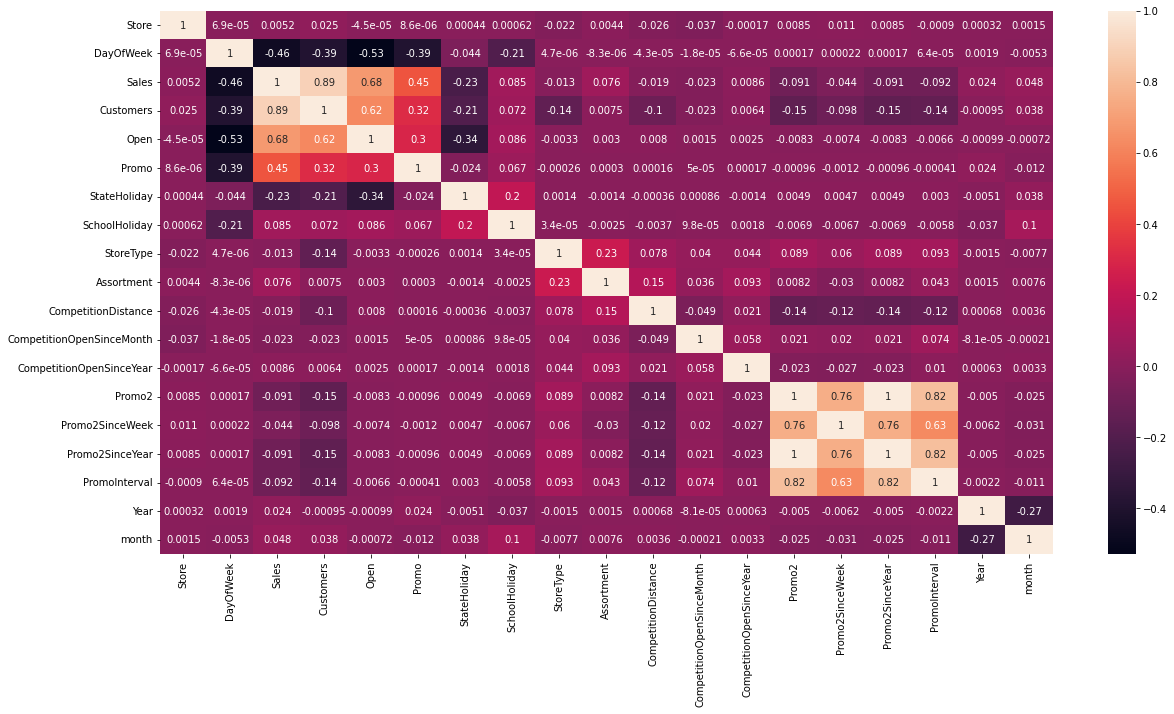

In [50]:
plt.figure(figsize=(20,10))
sns.heatmap(df_clean.corr(),annot=True)
plt.show()

- Sales is highly correlated with Customers, Open, Promo code
- Promo code is highly correlated to Promo2SinceWeek, Promo2SinceYear, PromoInterval

## **Modeling**

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import math  

In [51]:
df_clean_open = df_clean[df_clean['Open'] == 1]
df_clean_closed = df_clean[df_clean['Open'] == 0]

In [53]:
x_train, x_test, y_train, y_test_open = train_test_split(df_clean_open.drop(['Sales','Customers', 'Open'],axis=1),
                                                    df_clean_open['Sales'],test_size=0.20)

### **Linear Regression**

In [54]:
from sklearn import linear_model

reg_model = linear_model.LinearRegression() # making regression model
reg_model.fit(x_train, y_train) 

prediction_open = reg_model.predict(x_test)

prediction_closed = np.zeros(df_clean_closed.shape[0])

prediction = np.append(prediction_open, prediction_closed)

y_test = np.append(y_test_open, np.zeros(df_clean_closed.shape[0]))

print("r2_score: ",r2_score(y_test,prediction))
print("Mean absolute error: %.2f" % mean_absolute_error(y_test,prediction))
print("Root mean squared error: ", math.sqrt(mean_squared_error(y_test,prediction)))

r2_score:  0.7741549053533321
Mean absolute error: 1001.72
Root mean squared error:  1950.412091516659


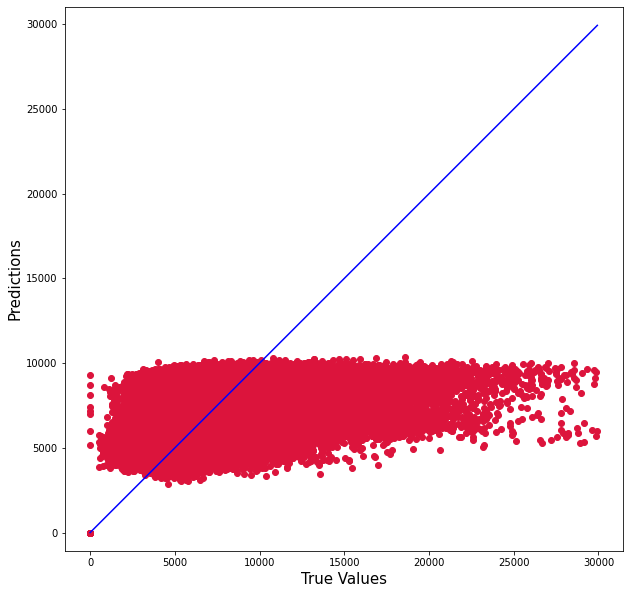

In [55]:
plt.figure(figsize=(10,10))
plt.scatter(y_test,prediction, c='crimson')

p1 = max(max(prediction), max(y_test))
p2 = min(min(prediction), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

### **Random Forest Regressor**

In [74]:
from sklearn.ensemble import RandomForestRegressor

random_forest_regressor_model = RandomForestRegressor()
random_forest_regressor_model.fit(x_train,y_train)

prediction_open = random_forest_regressor_model.predict(x_test)
prediction_closed = np.zeros(df_clean_closed.shape[0])

prediction = np.append(prediction_open, prediction_closed)

y_test = np.append(y_test_open, np.zeros(df_clean_closed.shape[0]))

print("r2_score: ",r2_score(y_test,prediction))
print("Mean absolute error: %.2f" % mean_absolute_error(y_test,prediction))
print("Root mean squared error: ", math.sqrt(mean_squared_error(y_test,prediction)))

r2_score:  0.9652146581499075
Mean absolute error: 358.61
Root mean squared error:  765.4541596838


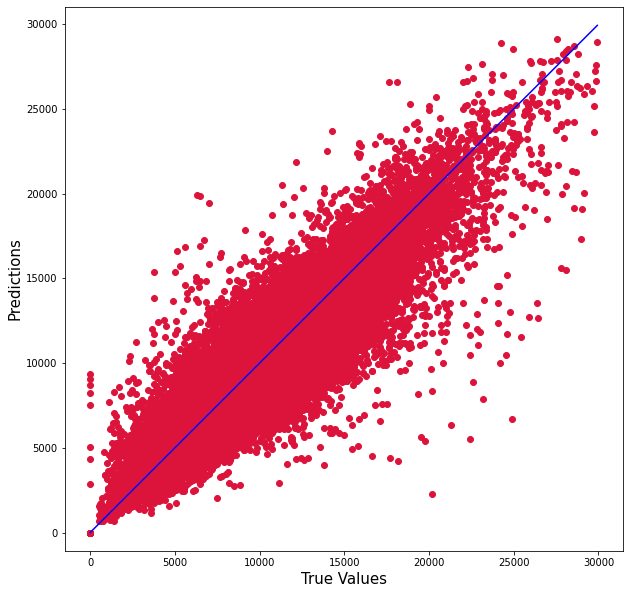

In [75]:
plt.figure(figsize=(10,10))
plt.scatter(y_test,prediction, c='crimson')

p1 = max(max(prediction), max(y_test))
p2 = min(min(prediction), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

### **Decision Tree Regressor**

In [60]:
from sklearn.tree import DecisionTreeRegressor

decision_tree_regressor_model = DecisionTreeRegressor()
decision_tree_regressor_model.fit(x_train,y_train)

prediction_open = decision_tree_regressor_model.predict(x_test)
prediction_closed = np.zeros(df_clean_closed.shape[0])

prediction = np.append(prediction_open, prediction_closed)

y_test = np.append(y_test_open, np.zeros(df_clean_closed.shape[0]))

print("r2_score: ",r2_score(y_test,prediction))
print("Mean absolute error: %.2f" % mean_absolute_error(y_test,prediction))
print("Root mean squared error: ", math.sqrt(mean_squared_error(y_test,prediction)))

r2_score:  0.9514898516979529
Mean absolute error: 422.89
Root mean squared error:  903.9353087723856


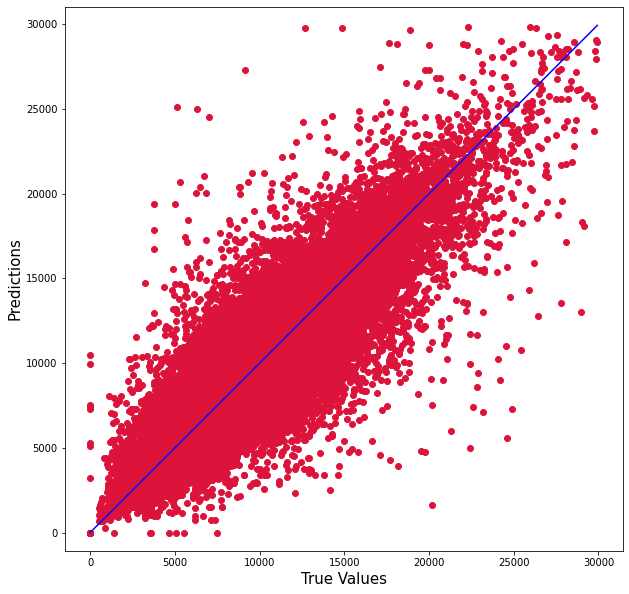

In [61]:
plt.figure(figsize=(10,10))
plt.scatter(y_test,prediction, c='crimson')

p1 = max(max(prediction), max(y_test))
p2 = min(min(prediction), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

### **Features Importance**

In [76]:
# getting weights of all the features used in the data
feature_importance = random_forest_regressor_model.feature_importances_
feature_importance

array([0.17917066, 0.08202116, 0.13971896, 0.00120757, 0.0125955 ,
       0.03636914, 0.03178667, 0.20710808, 0.0705674 , 0.07529587,
       0.00338033, 0.02872895, 0.0329055 , 0.01247709, 0.02371604,
       0.06295108])

In [77]:
# features used
columns = list(x_train.columns)
columns

['Store',
 'DayOfWeek',
 'Promo',
 'StateHoliday',
 'SchoolHoliday',
 'StoreType',
 'Assortment',
 'CompetitionDistance',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Promo2',
 'Promo2SinceWeek',
 'Promo2SinceYear',
 'PromoInterval',
 'Year',
 'month']

In [78]:
feature_importance_value = []
for i in range(len(feature_importance)):
    feature_importance_value.append(round(feature_importance[i],5))
feature_importance_value

[0.17917,
 0.08202,
 0.13972,
 0.00121,
 0.0126,
 0.03637,
 0.03179,
 0.20711,
 0.07057,
 0.0753,
 0.00338,
 0.02873,
 0.03291,
 0.01248,
 0.02372,
 0.06295]

In [79]:
# making a dataframe
feature_importance_df = pd.DataFrame({"Features":columns,
                                     "Values":feature_importance_value })
feature_importance_df

,Features,Values
0,Store,0.17917
1,DayOfWeek,0.08202
2,Promo,0.13972
3,StateHoliday,0.00121
4,SchoolHoliday,0.01260
5,StoreType,0.03637
6,Assortment,0.03179
7,CompetitionDistance,0.20711
8,CompetitionOpenSinceMonth,0.07057
9,CompetitionOpenSinceYear,0.07530


In [80]:
feature_importance_df.sort_values(by=["Values"], inplace=True, ascending=False)
feature_importance_df

,Features,Values
7,CompetitionDistance,0.20711
0,Store,0.17917
2,Promo,0.13972
1,DayOfWeek,0.08202
9,CompetitionOpenSinceYear,0.07530
8,CompetitionOpenSinceMonth,0.07057
15,month,0.06295
5,StoreType,0.03637
12,Promo2SinceYear,0.03291
6,Assortment,0.03179


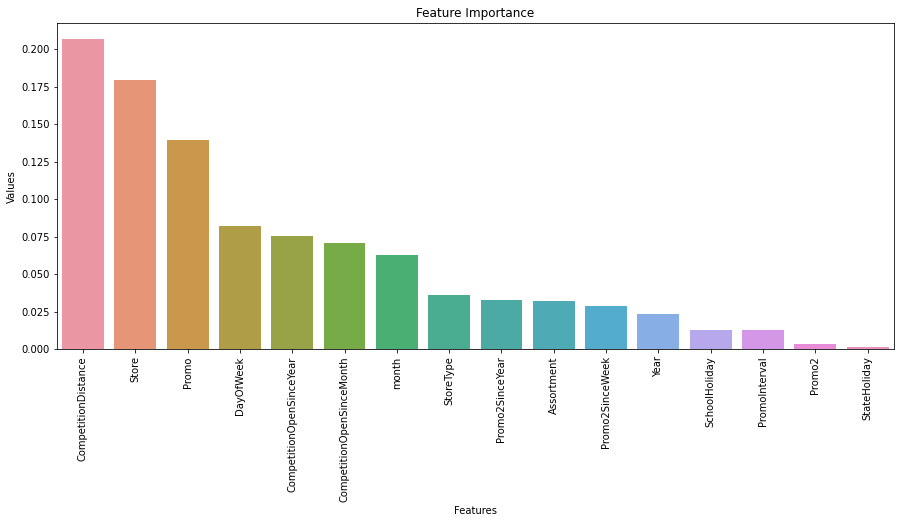

In [81]:
# Feature Importance
plt.figure(figsize=(15,6))

sns.barplot(x=feature_importance_df['Features'], y=feature_importance_df['Values'],
            data = feature_importance_df ).set(title='Feature Importance')

plt.xticks(rotation=90)
plt.show()